In [1]:
import hhgen.plots as plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler

In [2]:
features = ['hh_m','hh_pt', 'hh_eta','hgg_pt_hh_m','hbb_pt_hh_m','cos_theta_cs','cos_theta_hbb','cos_theta_hgg']
features+=['leadJet_pt','leadJet_eta','subleadJet_pt','subleadJet_eta']
features+=['leadPho_pt','leadPho_eta','subleadPho_pt','subleadPho_eta']

scaler=RobustScaler()

In [3]:
#merging nodes
node_6=pd.read_hdf("node_6.hd5")
node_9=pd.read_hdf("node_9.hd5")
node_4=pd.read_hdf("node_4.hd5")
node_SM=pd.read_hdf("node_SM.hd5")

frames=[node_6,node_9,node_4,node_SM]
df=pd.concat(frames)

#indexing
random_index = np.arange(df.shape[0]) 
np.random.shuffle(random_index)
df["random_index"]=random_index 
df.set_index("random_index",inplace=True)
df.sort_index(inplace=True)

In [4]:
#training
X = df[features]
y = df['cat'] 
w = df['weight']

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2, random_state=12351)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

#reweighting and clipping it at optimum 
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,20)
w_train*=rw[y_train]

clf=XGBClassifier(max_depth=3, n_estimators=500, n_jobs=8, objective='multi:softmax', subsample=0.8,
                 reg_lambda=0.5, learning_rate=0.5)
%time clf.fit(X_train,y_train,w_train)

CPU times: user 10min 38s, sys: 19.6 s, total: 10min 57s
Wall time: 1min 22s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=8, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [5]:
#reset indices
X_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
w_test.reset_index(drop=True,inplace=True)

Weighted least squares for true/pred plot:  13.0916
Weighted least squares for true/pred plot without category 0:  13.0894
Spread for truth/pred plot:  0.148512


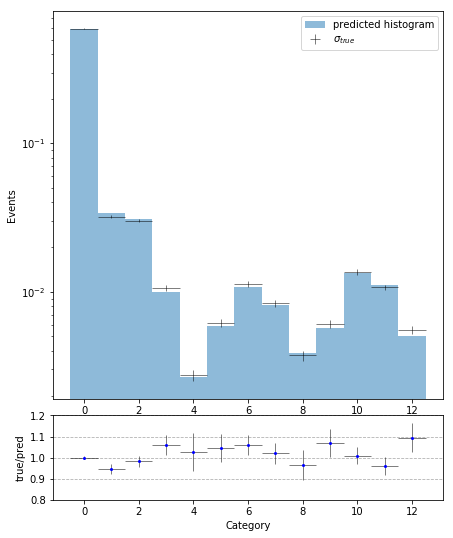

In [6]:
#predicting renormalised probability of each data in test set according to category 
y_pred_prob=clf.predict_proba(X_test)
y_pred_prob/=rw.reshape(1,-1) 
y_pred_prob/=np.sum(y_pred_prob,axis=1,keepdims=True)
#predicting weight of each data in test set according to category
y_pred_weight=np.multiply(y_pred_prob,w_test.reshape(-1,1))
#predicted categories in the form- number of test samples*number of categories
y_pred= np.arange(13).reshape(1,-1)*np.ones_like(y_pred_weight)

plots.plotting(y_pred.ravel(),y_pred_weight.ravel(),y_test,w_test)

In [7]:
#scaling data back
X_test=pd.DataFrame(scaler.inverse_transform(X_test))

In [8]:
#predicted
y_pred=np.argmax(y_pred_prob,axis=1)
w_pred=np.array([])
for i in range(0,len(y_pred_weight)):
    array=y_pred_weight[i]
    cat=y_pred[i]
    weight=array[cat]
    w_pred=np.append(w_pred,weight)
    
y_pred=pd.DataFrame(y_pred)
w_pred=pd.DataFrame(w_pred)

frames=[X_test,y_test,w_test,y_pred,w_pred]
df = pd.concat(frames,axis=1,ignore_index=True)

df.columns=['hh_m','hh_pt', 'hh_eta','hgg_pt_hh_m','hbb_pt_hh_m','cos_theta_cs','cos_theta_hbb','cos_theta_hgg',
            'leadJet_pt','leadJet_eta','subleadJet_pt','subleadJet_eta','leadPho_pt','leadPho_eta',
            'subleadPho_pt','subleadPho_eta','cat_true','w_true','cat_pred','w_pred']

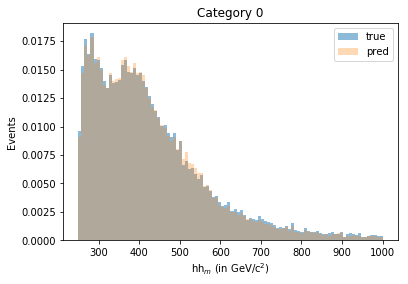

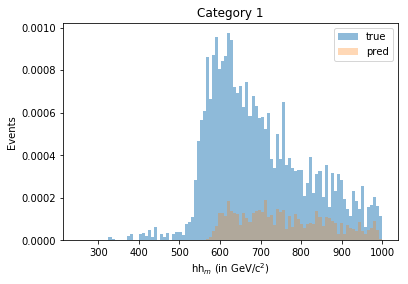

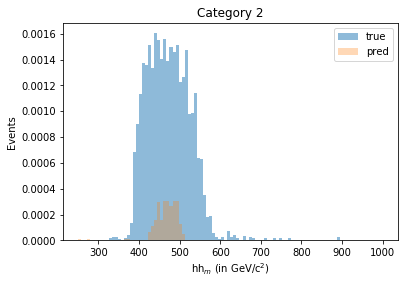

/t3home/gpoddar/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6097: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 0 x 1)
  '(shape is %d x %d)' % inp.shape[::-1])


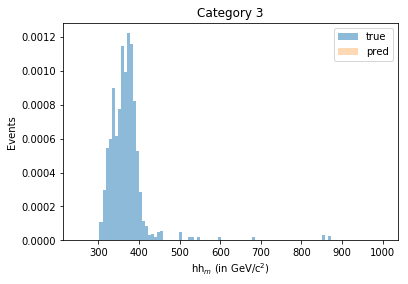

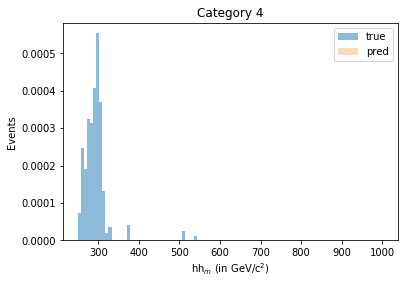

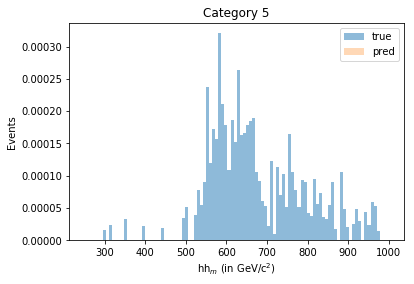

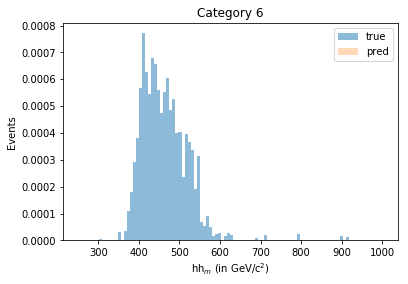

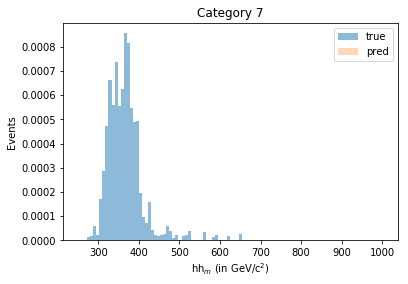

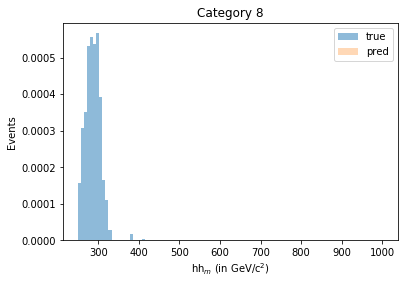

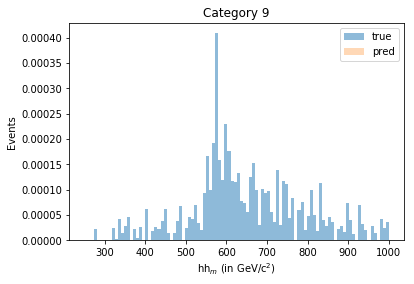

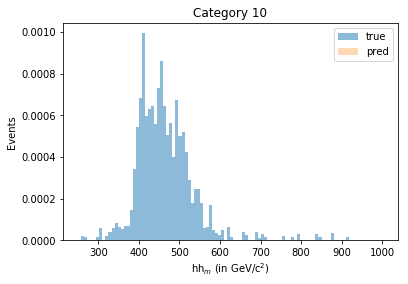

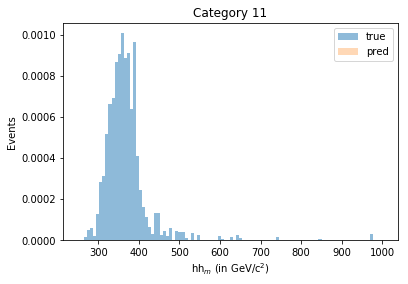

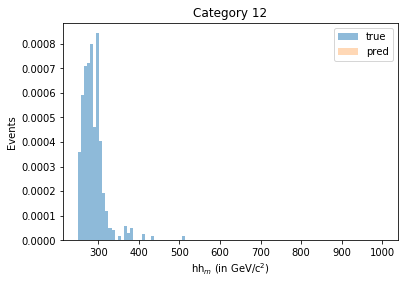

In [9]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(cat_true['hh_m'].ravel(),range=[250,1000],weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(cat_pred['hh_m'].ravel(),range=[250,1000],weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("hh$_m$ (in GeV/c$^2$)")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()

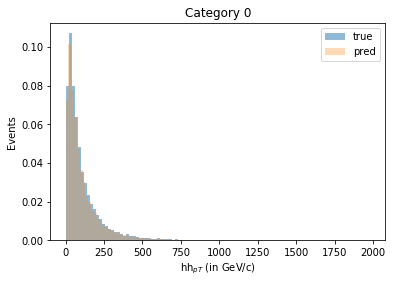

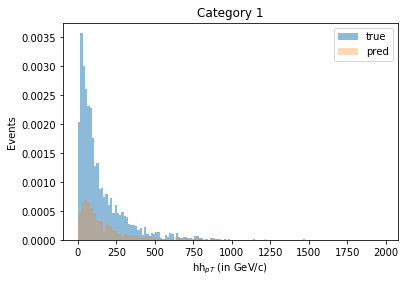

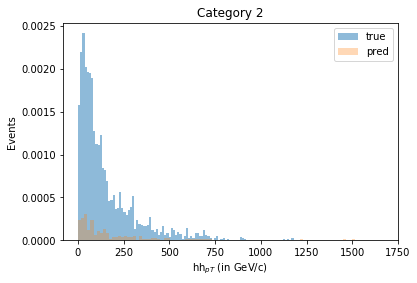

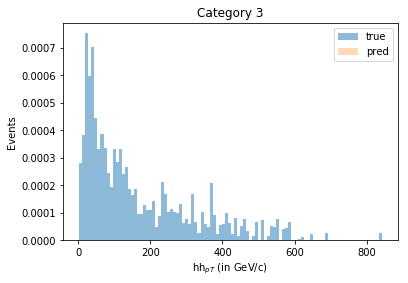

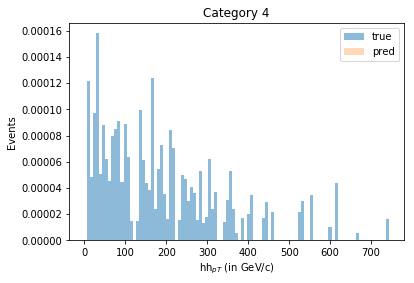

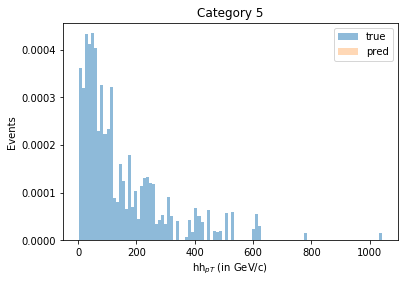

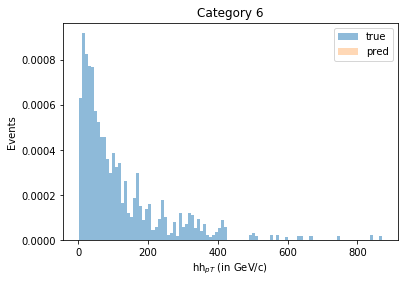

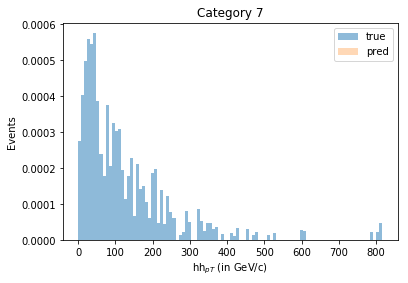

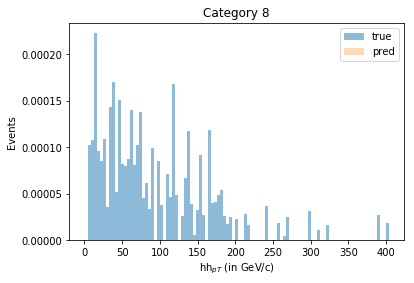

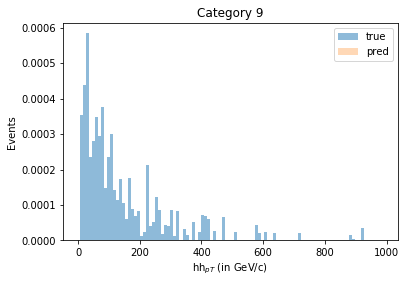

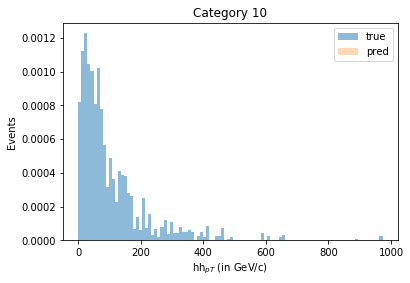

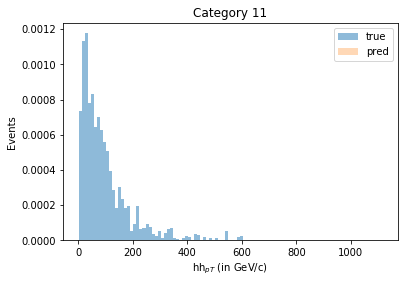

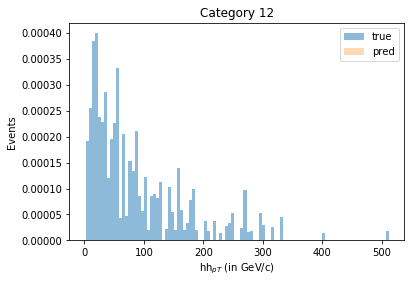

In [10]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(cat_true['hh_pt'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(cat_pred['hh_pt'].ravel(),weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("hh$_{pT}$ (in GeV/c)")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()

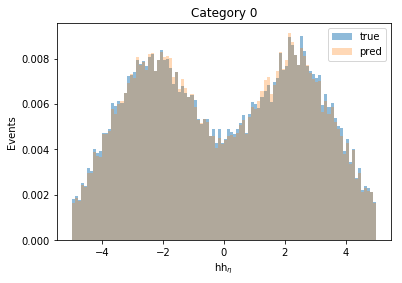

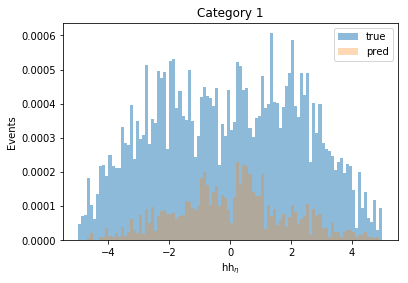

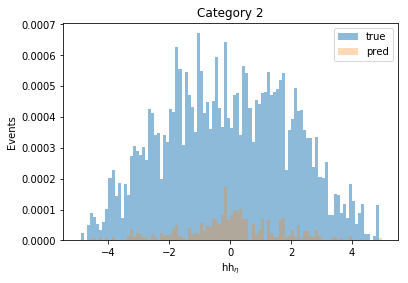

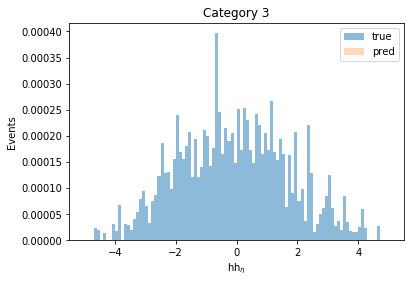

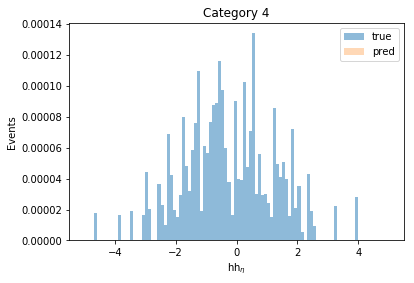

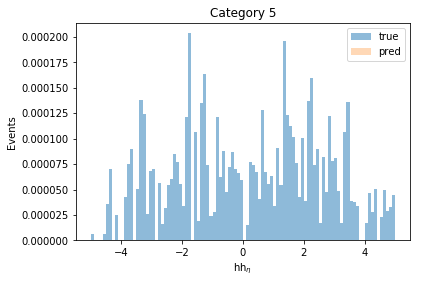

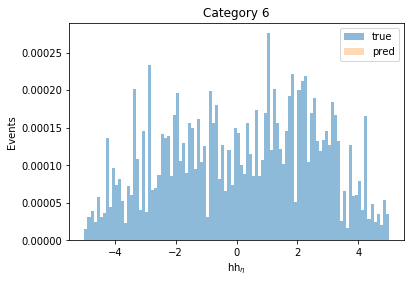

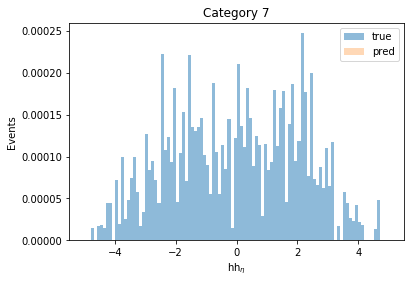

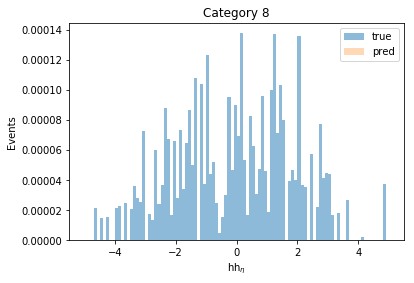

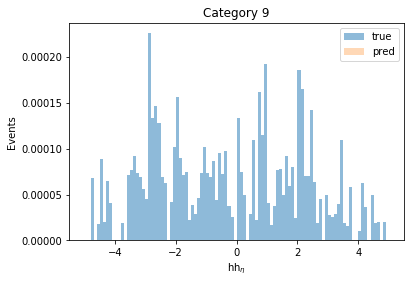

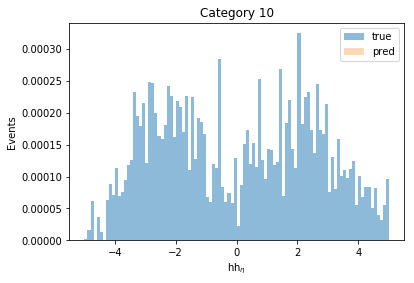

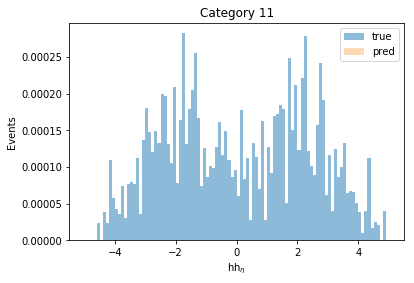

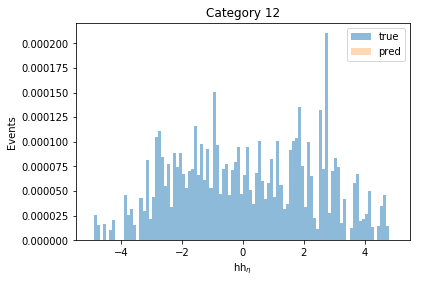

In [11]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(cat_true['hh_eta'].ravel(),range=[-5,5],weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(cat_pred['hh_eta'].ravel(),range=[-5,5],weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("hh$_{\eta}$")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()

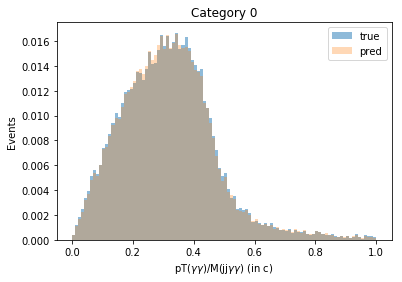

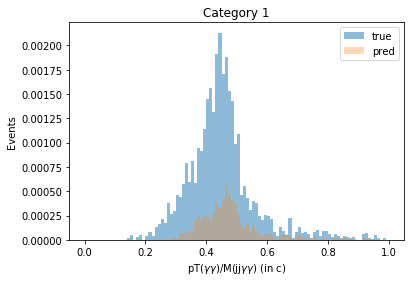

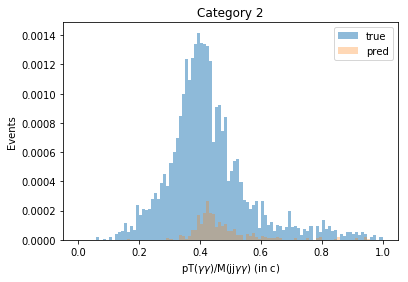

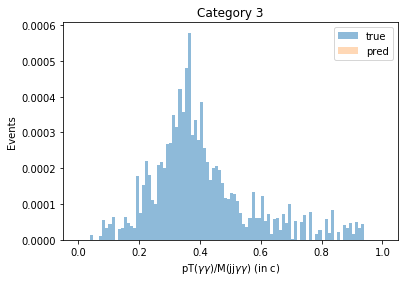

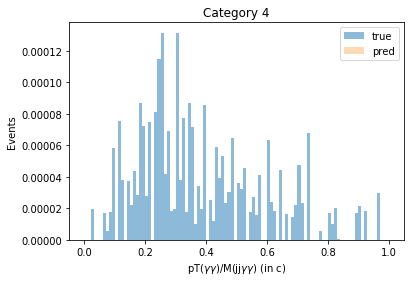

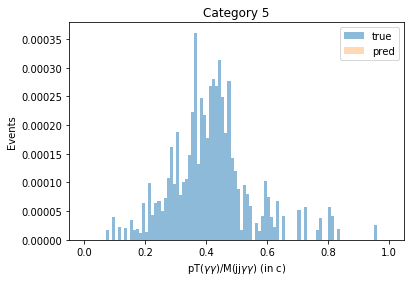

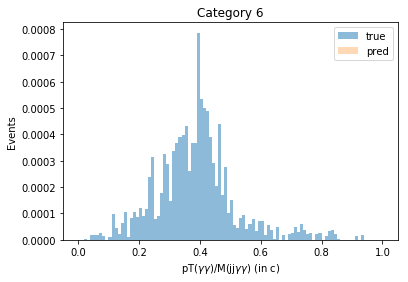

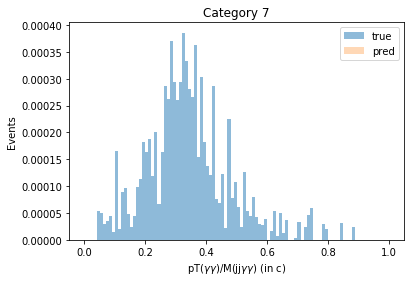

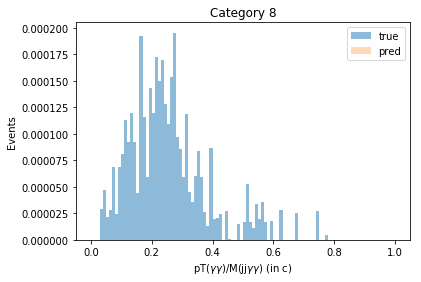

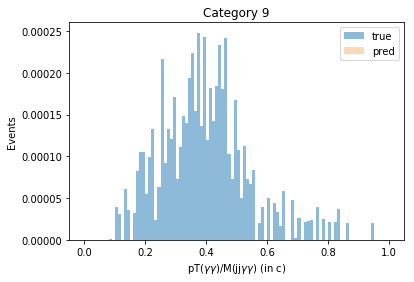

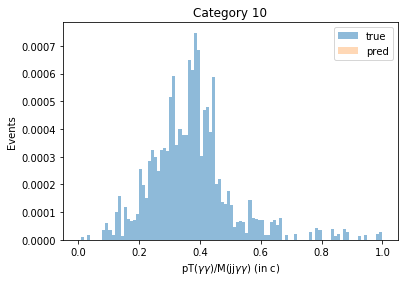

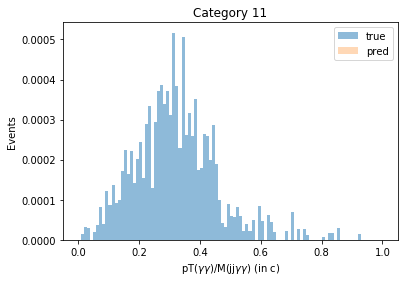

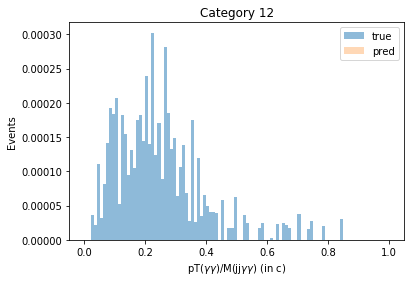

In [12]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(cat_true['hgg_pt_hh_m'].ravel(),range=[0,1],weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(cat_pred['hgg_pt_hh_m'].ravel(),range=[0,1],weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("pT($\gamma\gamma$)/M(jj$\gamma\gamma$) (in c)")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()

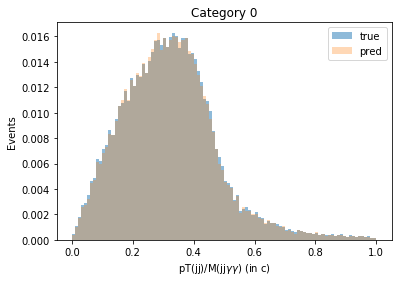

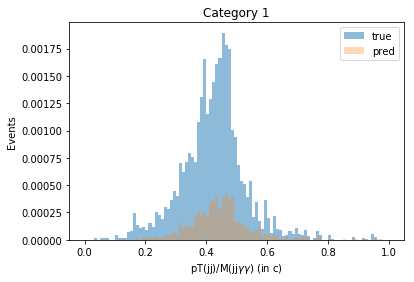

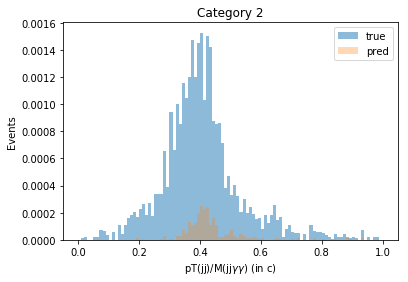

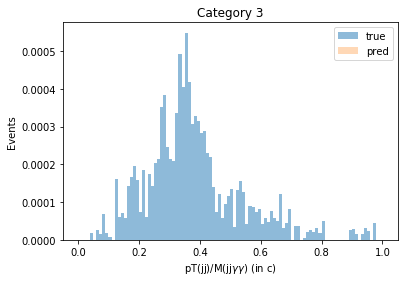

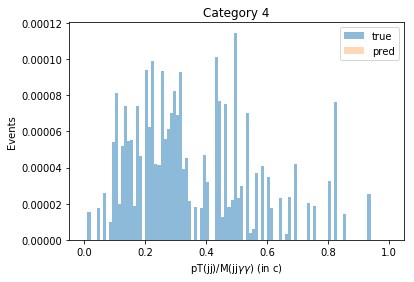

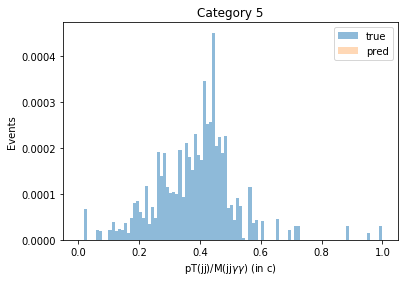

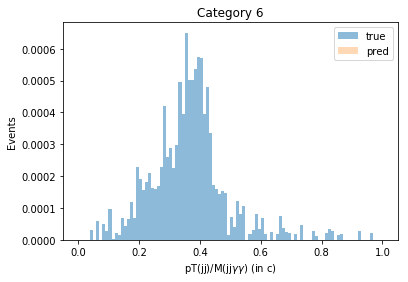

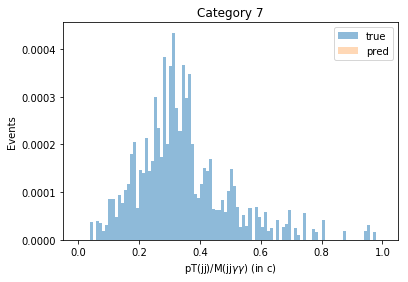

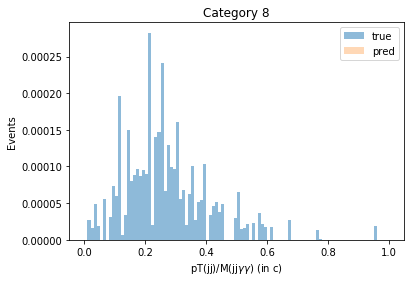

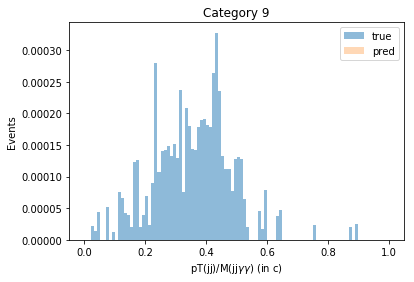

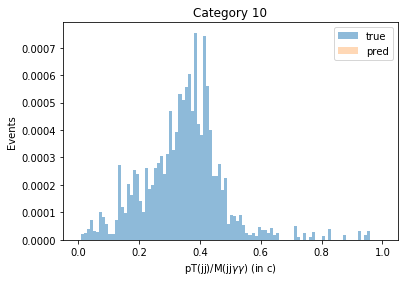

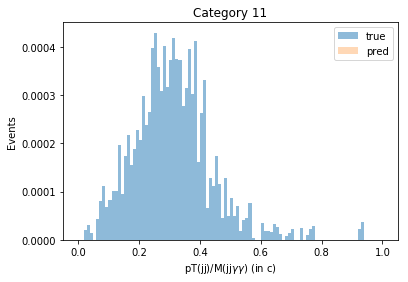

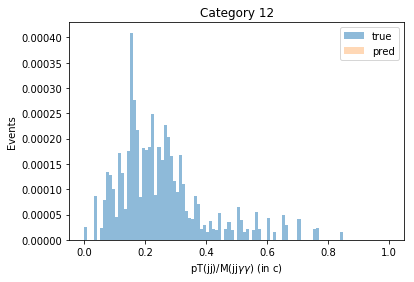

In [13]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(cat_true['hbb_pt_hh_m'].ravel(),range=[0,1],weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(cat_pred['hbb_pt_hh_m'].ravel(),range=[0,1],weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("pT(jj)/M(jj$\gamma\gamma$) (in c)")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()

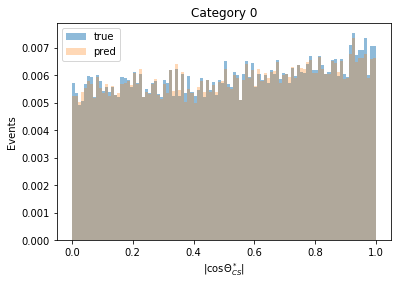

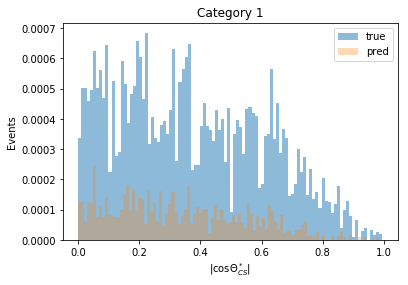

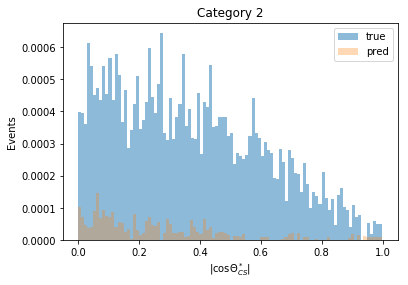

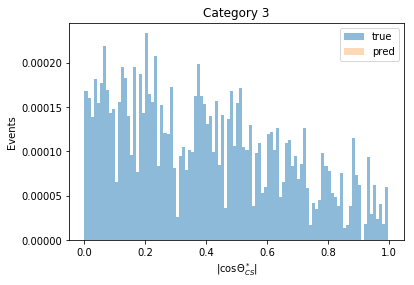

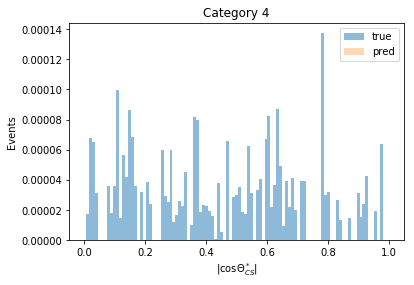

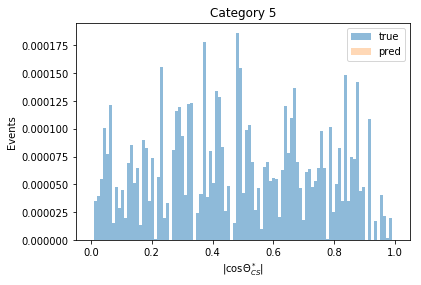

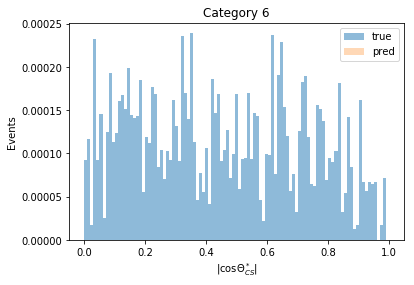

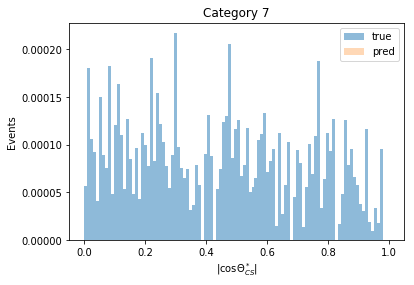

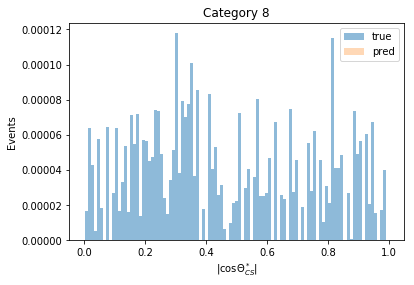

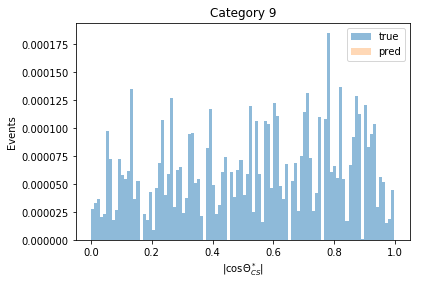

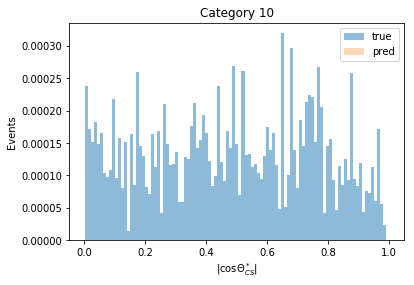

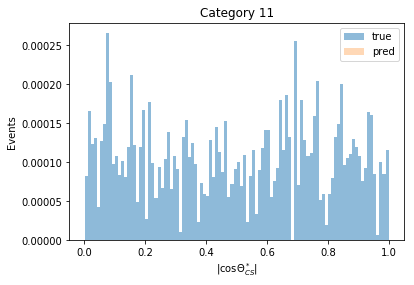

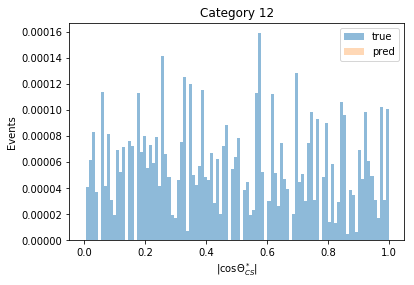

In [14]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(np.abs(cat_true['cos_theta_cs'].ravel()),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(np.abs(cat_pred['cos_theta_cs'].ravel()),weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("|cos$\Theta_{CS}^*$|")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()

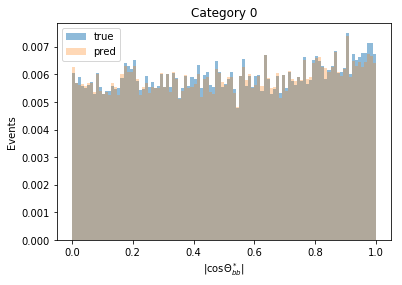

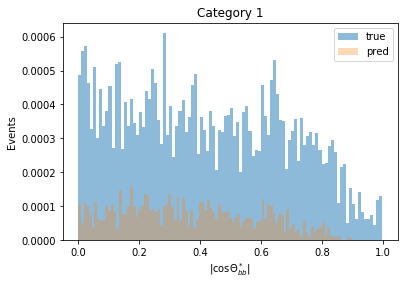

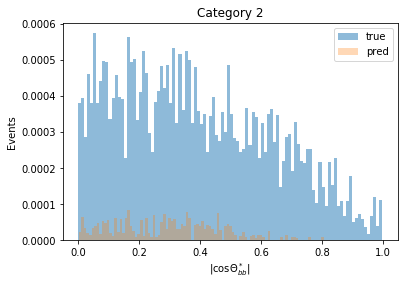

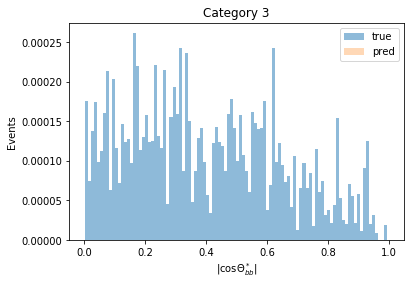

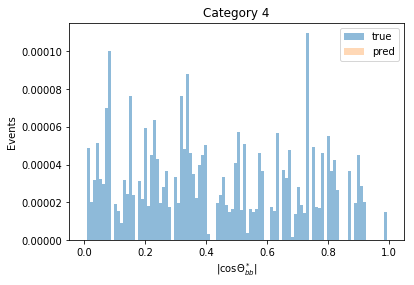

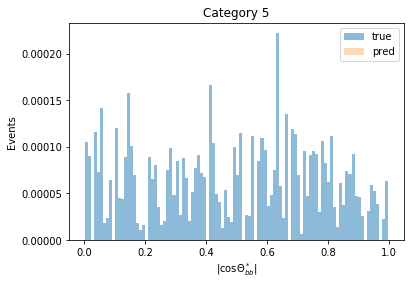

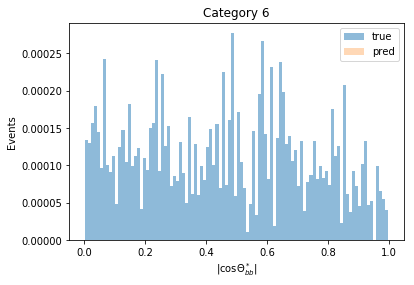

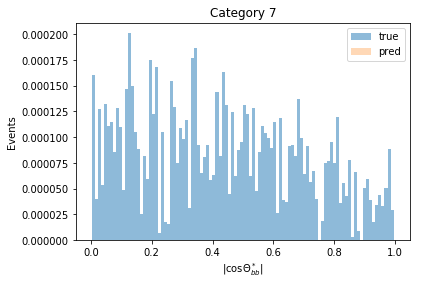

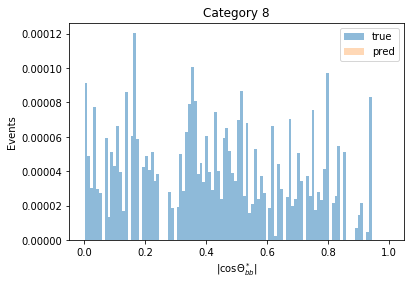

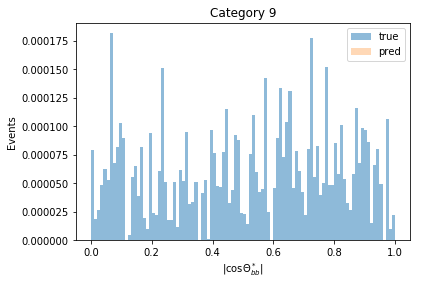

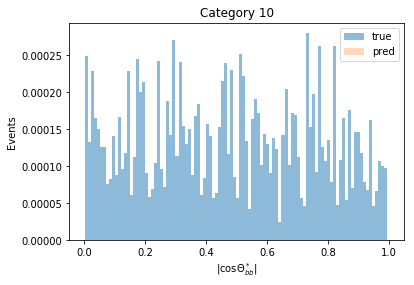

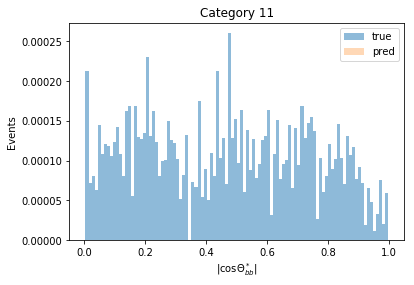

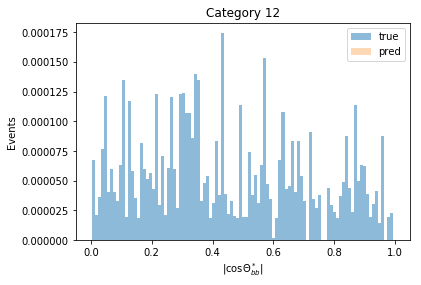

In [15]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(np.abs(cat_true['cos_theta_hbb'].ravel()),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(np.abs(cat_pred['cos_theta_hbb'].ravel()),weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("|cos$\Theta_{bb}^*$|")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()

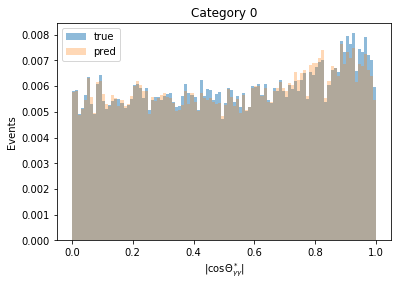

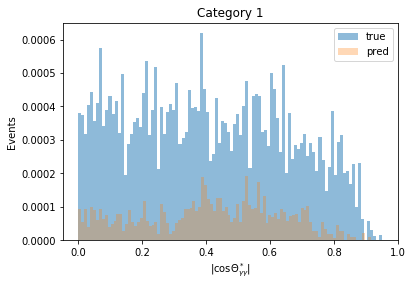

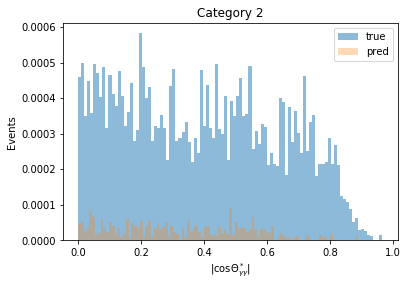

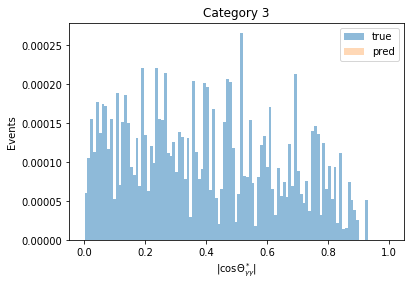

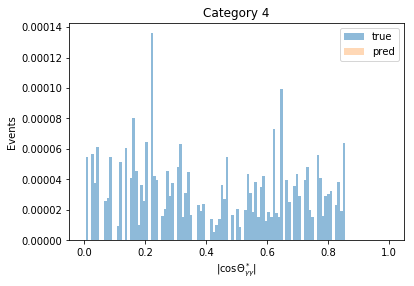

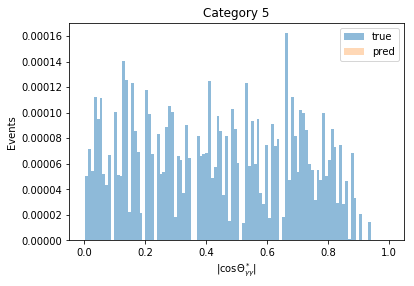

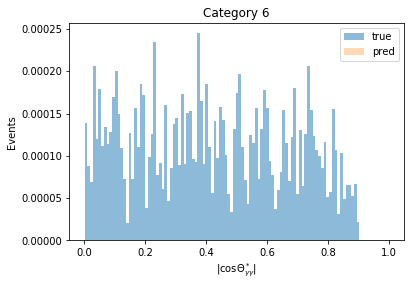

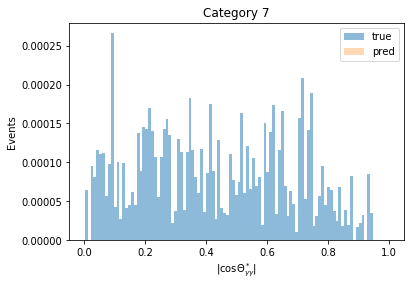

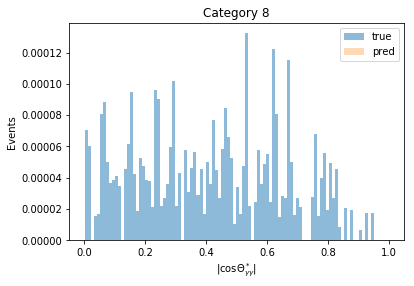

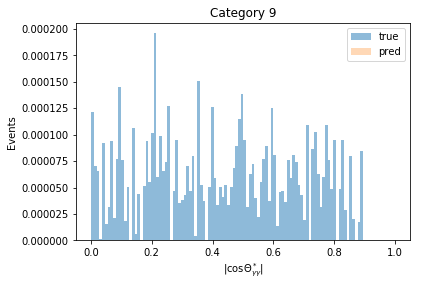

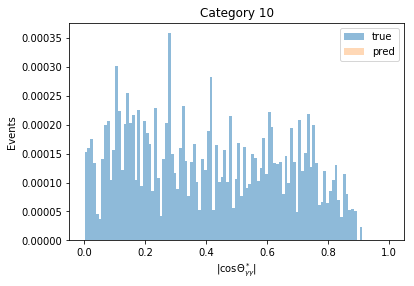

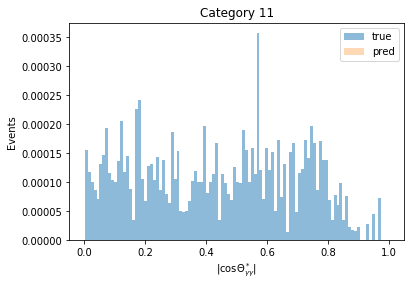

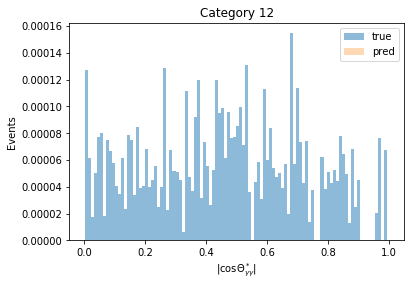

In [16]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(np.abs(cat_true['cos_theta_hgg'].ravel()),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(np.abs(cat_pred['cos_theta_hgg'].ravel()),weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("|cos$\Theta_{\gamma\gamma}^*$|")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()

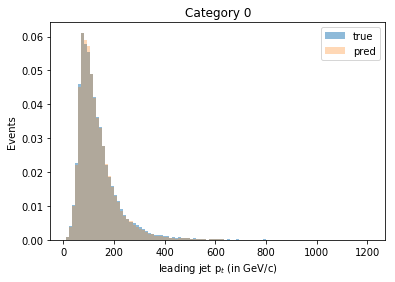

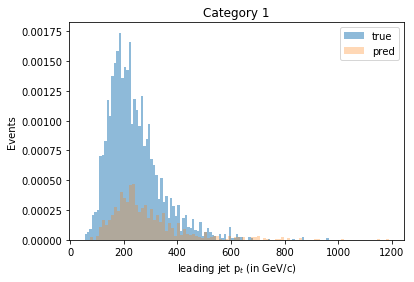

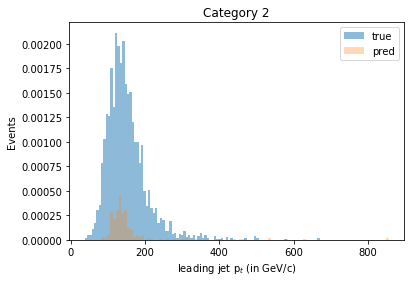

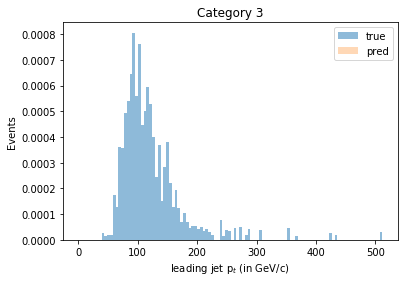

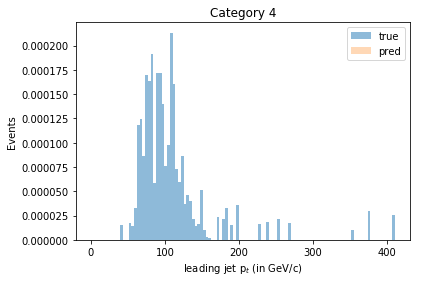

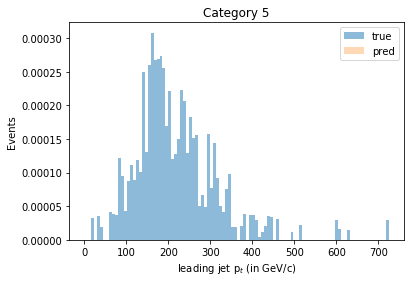

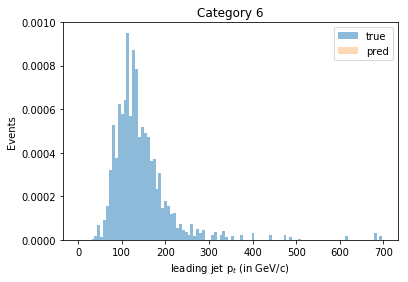

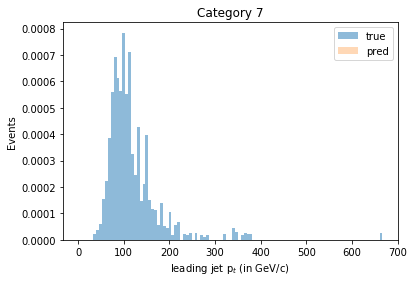

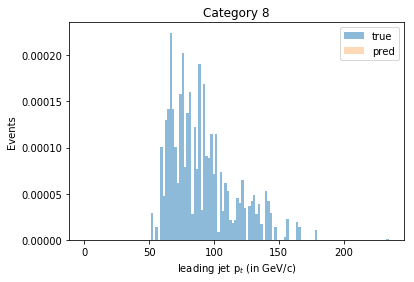

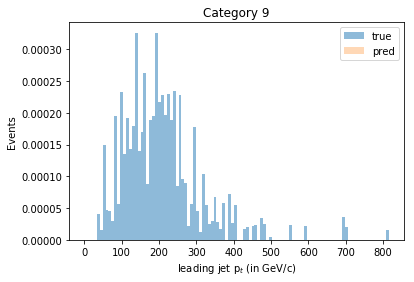

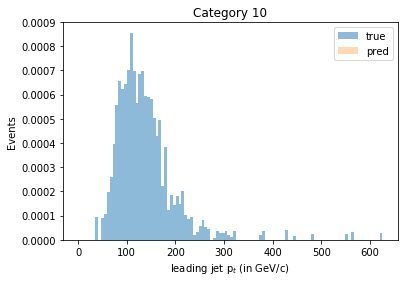

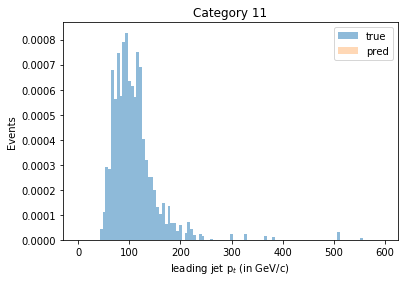

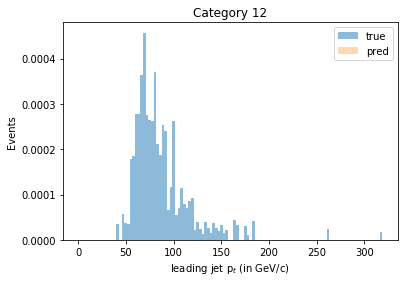

In [17]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(cat_true['leadJet_pt'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(cat_pred['leadJet_pt'].ravel(),weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("leading jet p$_t$ (in GeV/c)")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()

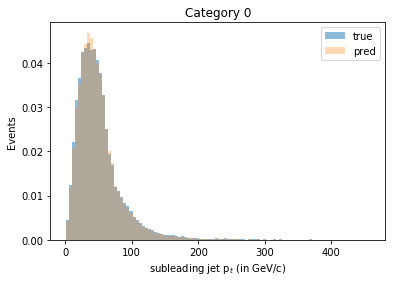

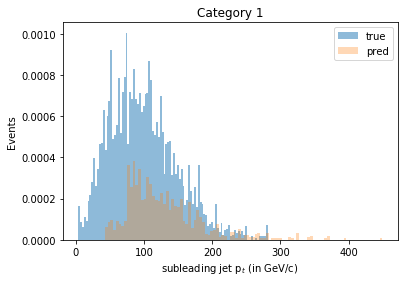

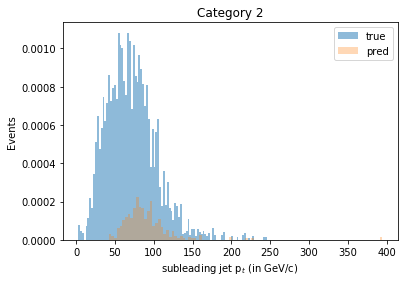

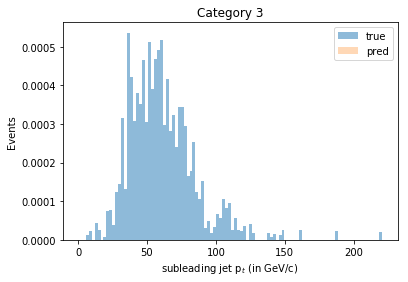

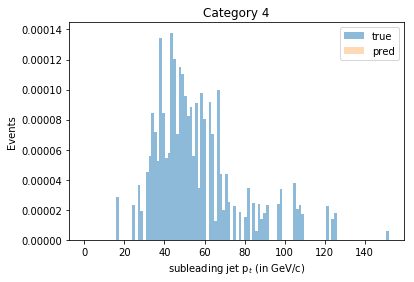

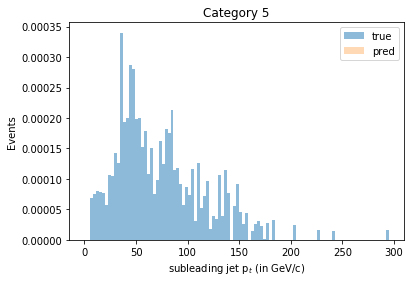

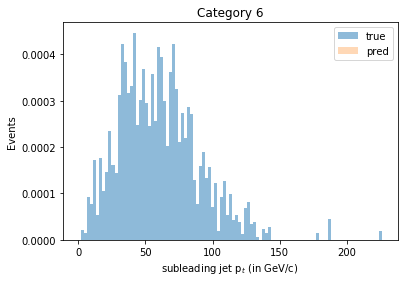

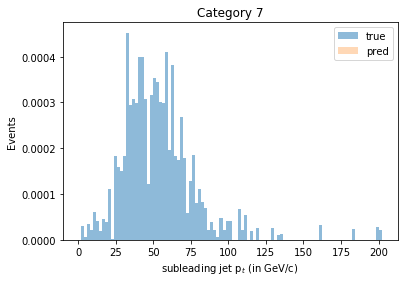

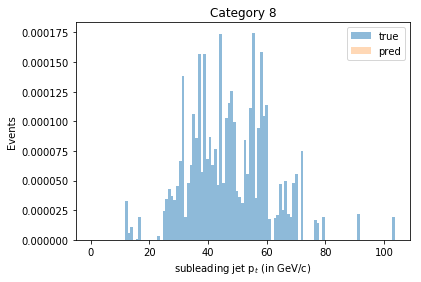

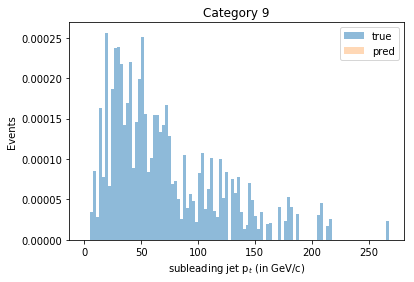

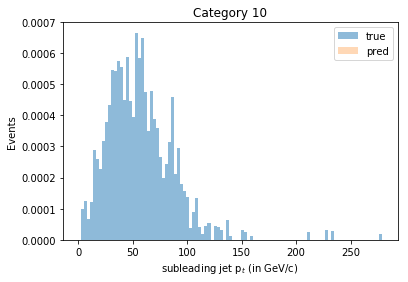

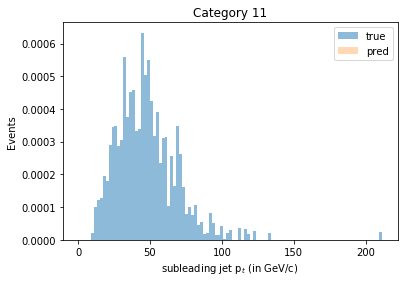

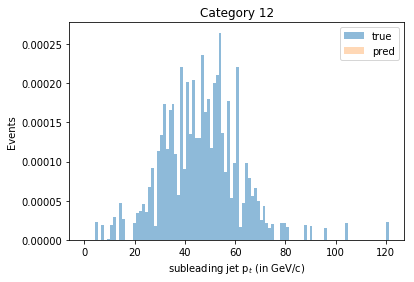

In [18]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(cat_true['subleadJet_pt'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(cat_pred['subleadJet_pt'].ravel(),weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("subleading jet p$_t$ (in GeV/c)")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()

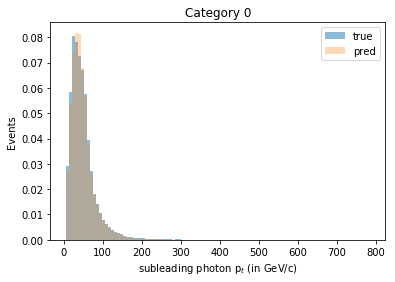

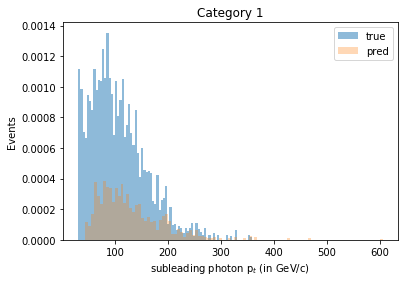

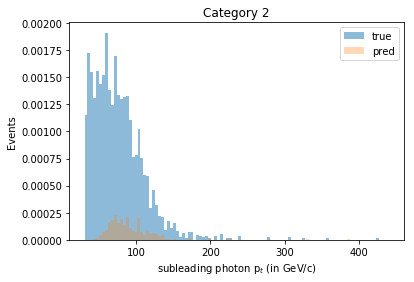

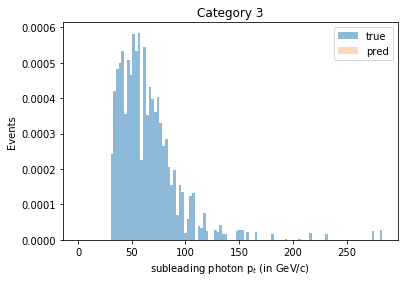

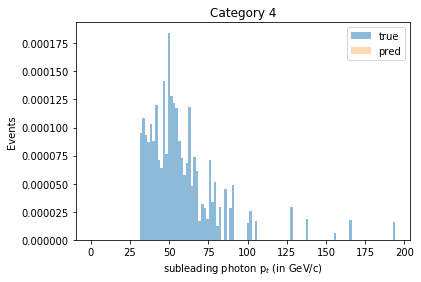

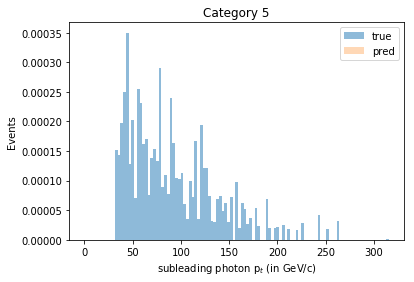

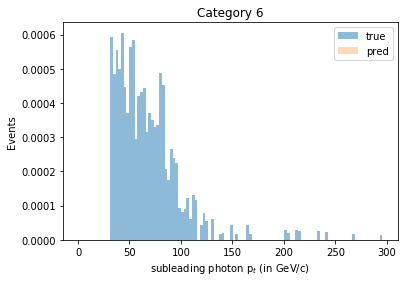

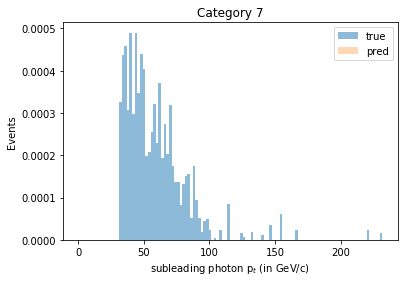

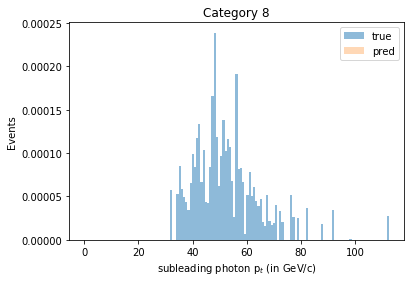

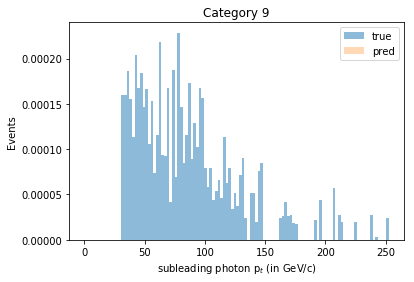

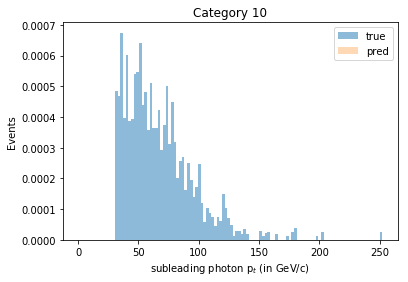

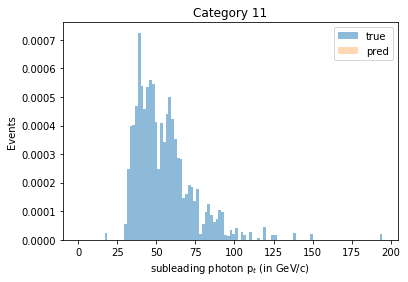

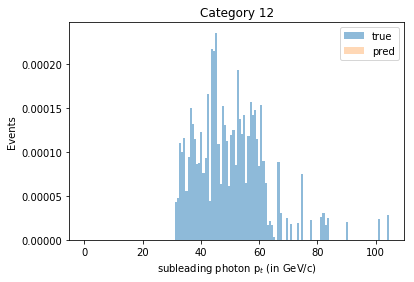

In [19]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(cat_true['subleadPho_pt'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(cat_pred['subleadPho_pt'].ravel(),weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("subleading photon p$_t$ (in GeV/c)")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()

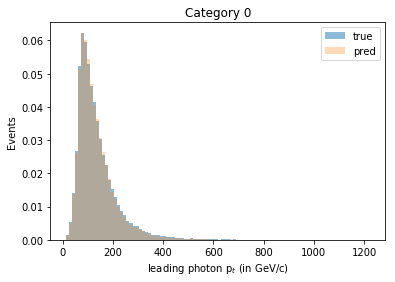

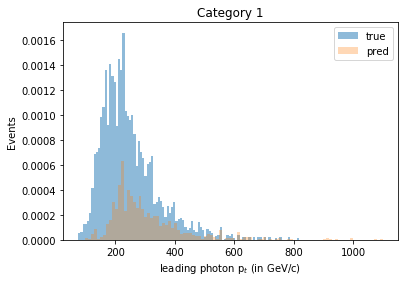

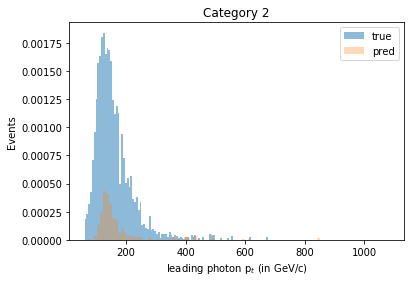

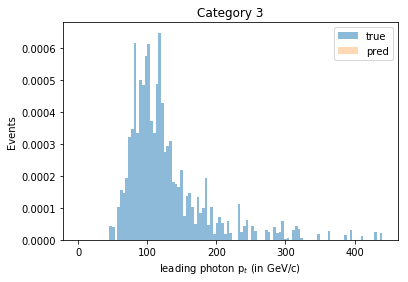

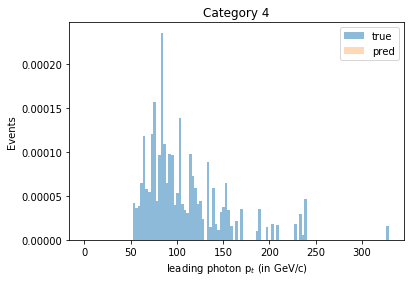

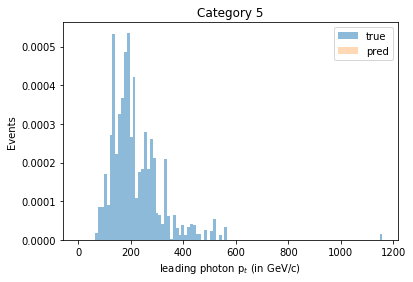

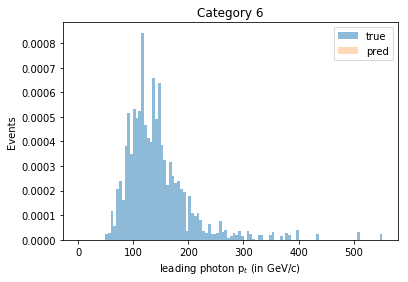

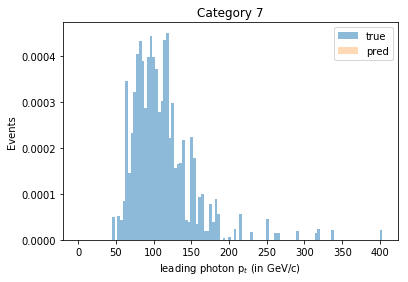

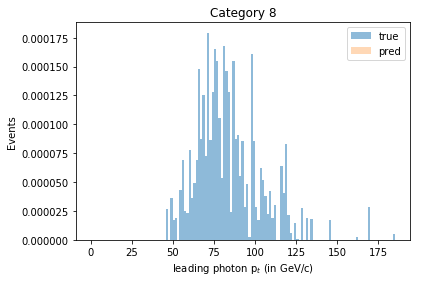

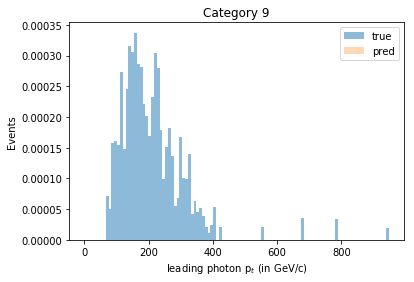

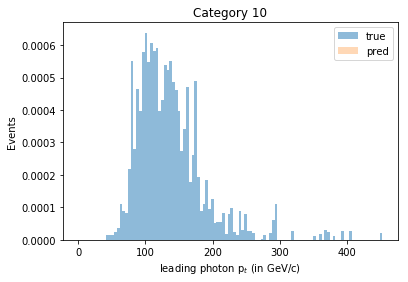

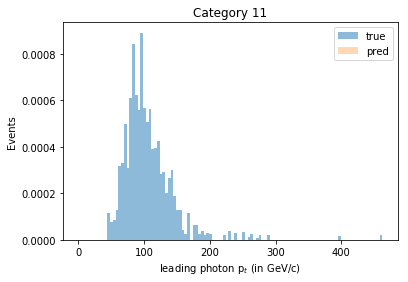

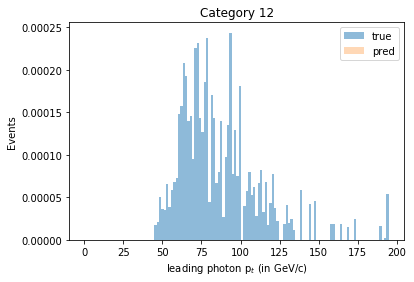

In [20]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(cat_true['leadPho_pt'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(cat_pred['leadPho_pt'].ravel(),weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("leading photon p$_t$ (in GeV/c)")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()

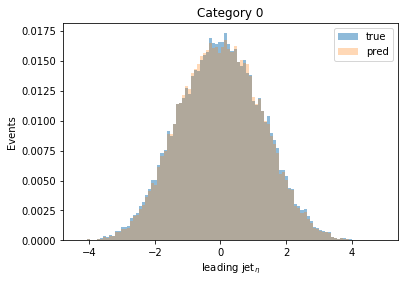

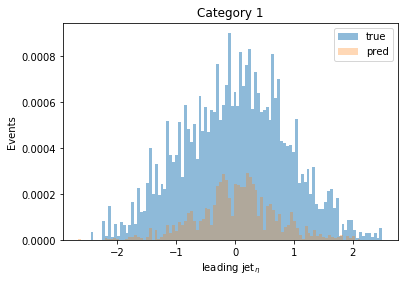

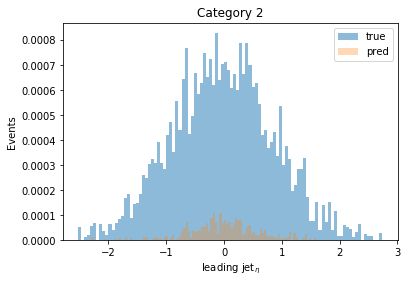

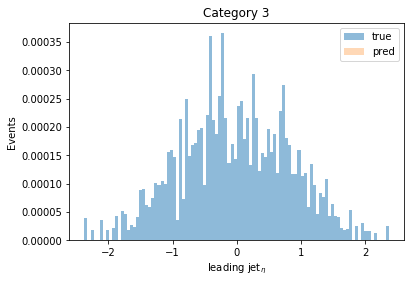

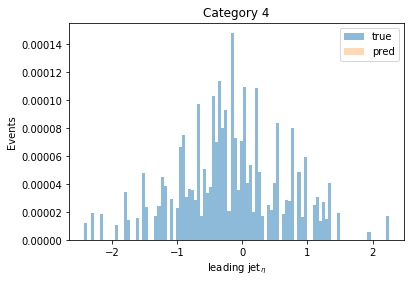

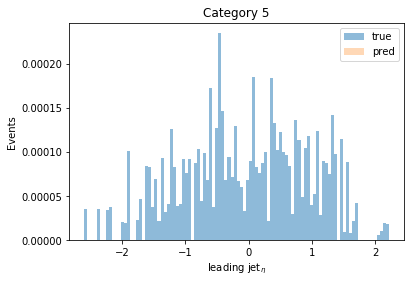

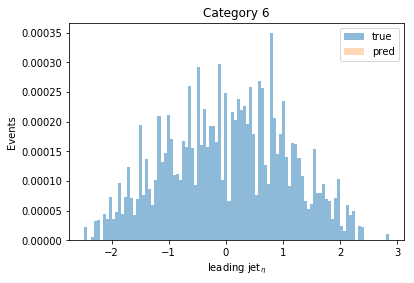

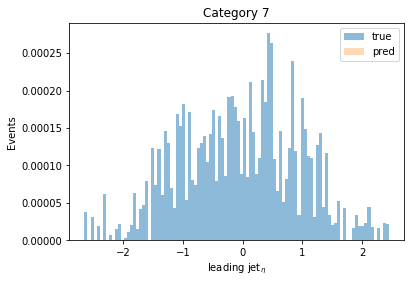

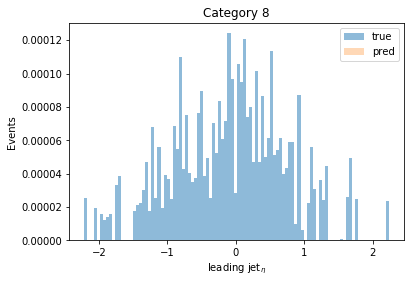

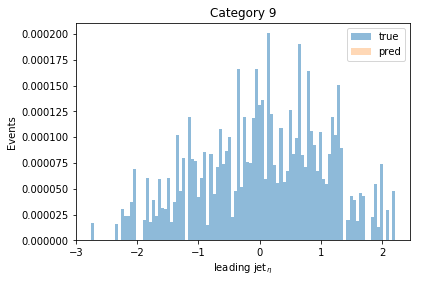

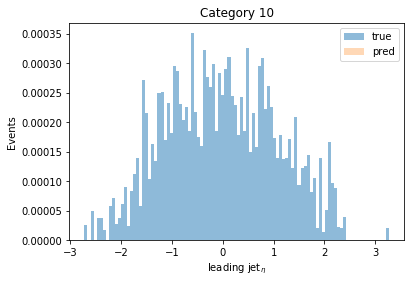

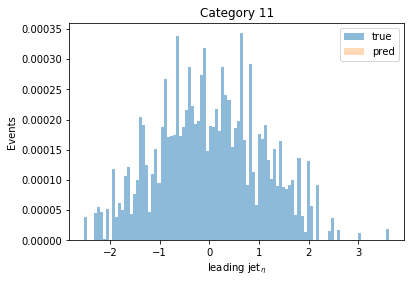

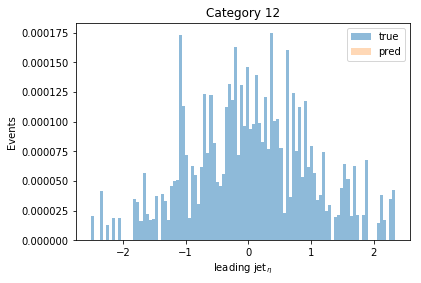

In [21]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(cat_true['leadJet_eta'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(cat_pred['leadJet_eta'].ravel(),weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("leading jet$_{\eta}$")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()

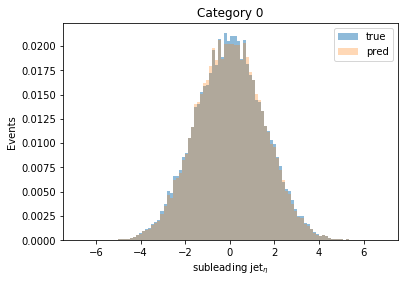

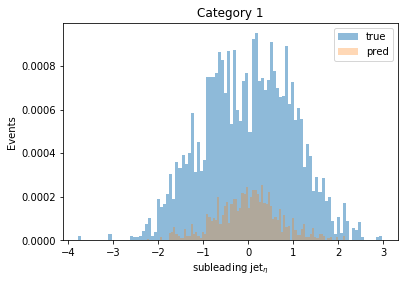

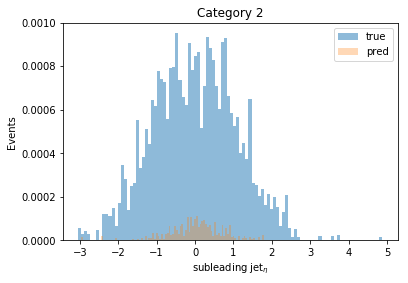

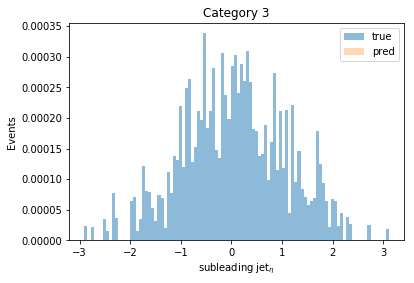

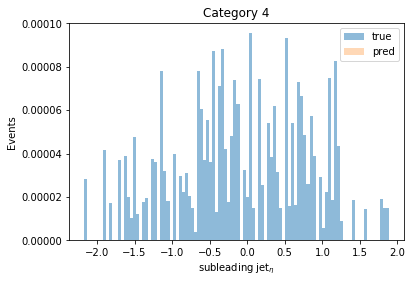

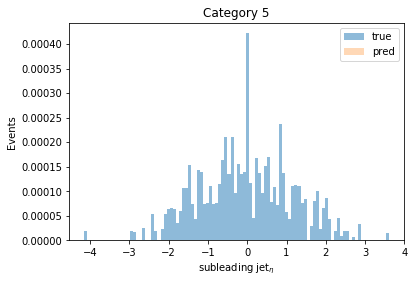

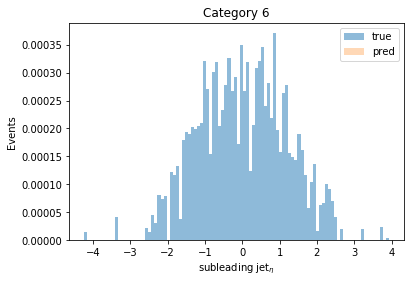

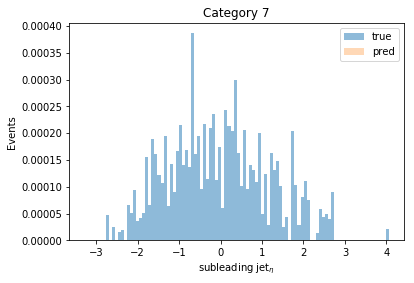

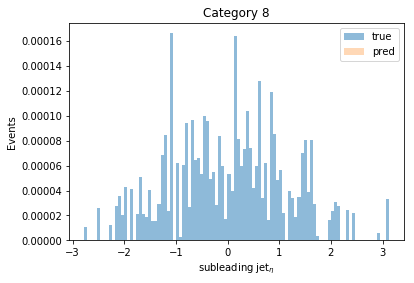

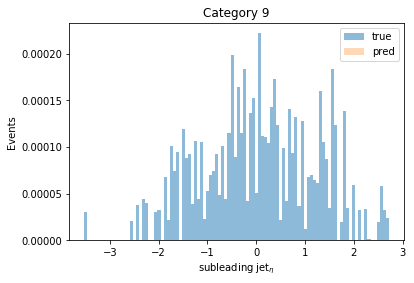

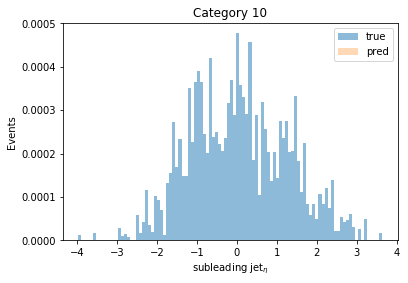

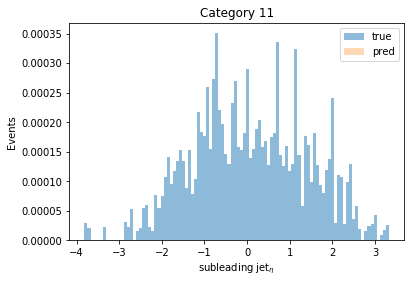

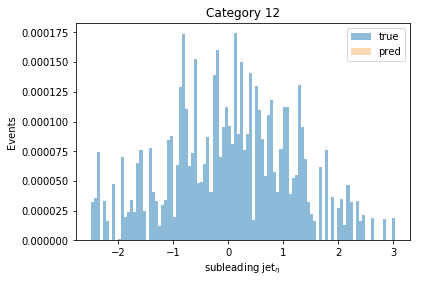

In [22]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(cat_true['subleadJet_eta'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(cat_pred['subleadJet_eta'].ravel(),weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("subleading jet$_{\eta}$")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()

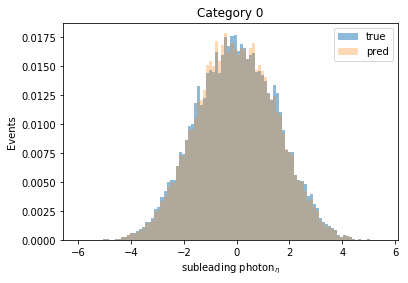

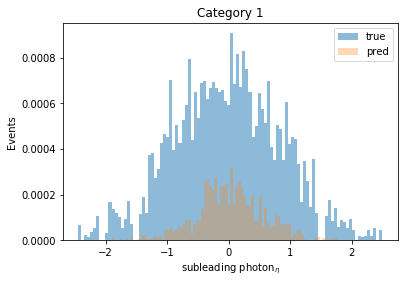

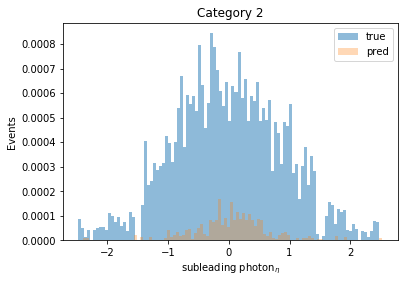

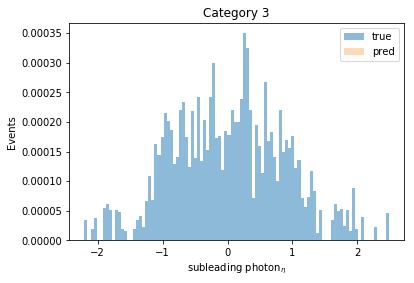

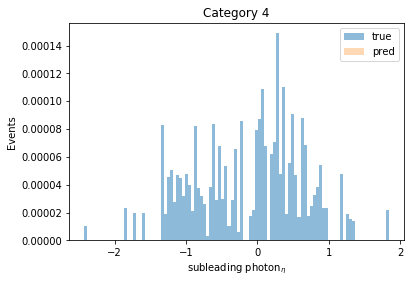

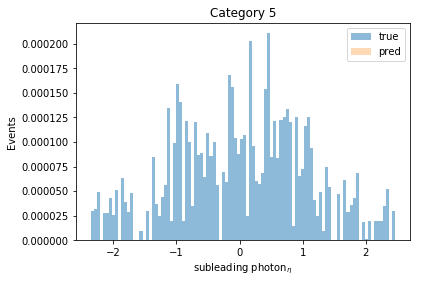

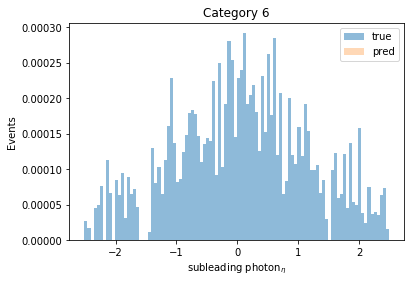

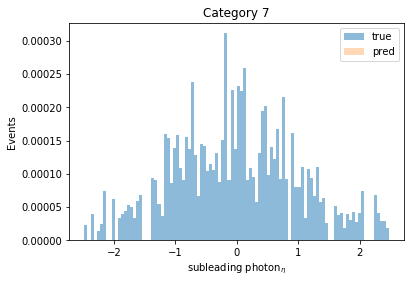

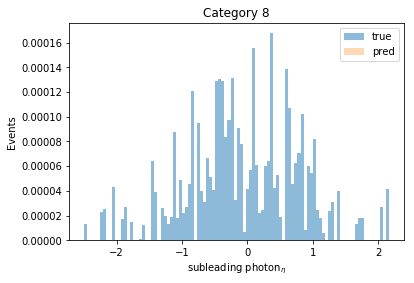

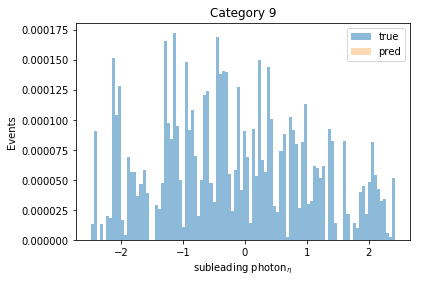

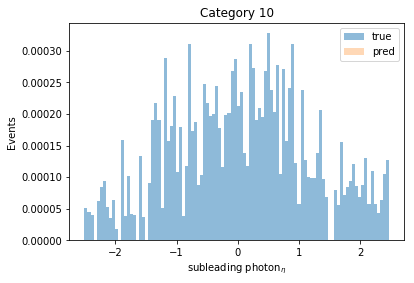

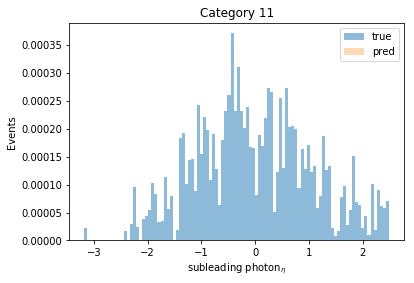

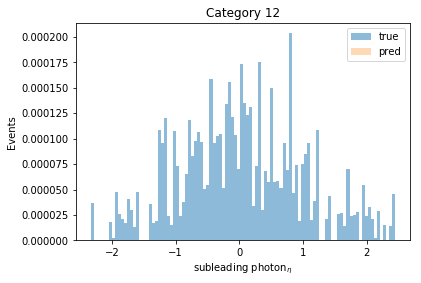

In [23]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(cat_true['subleadPho_eta'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(cat_pred['subleadPho_eta'].ravel(),weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("subleading photon$_{\eta}$")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()

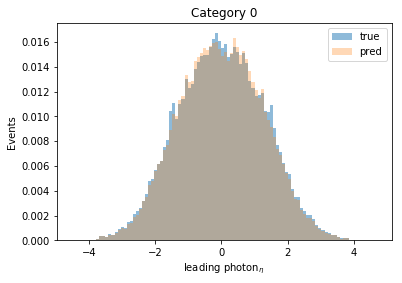

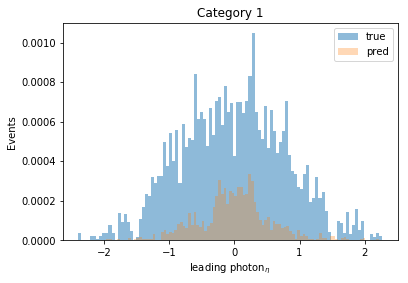

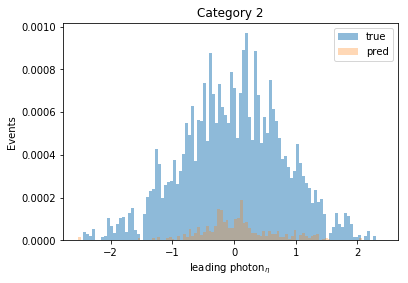

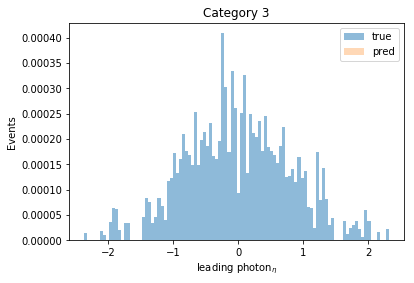

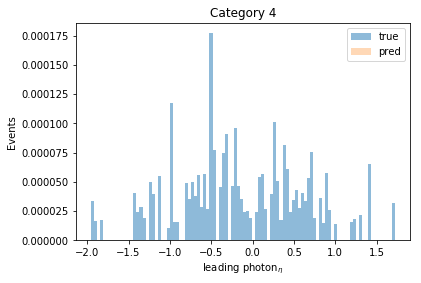

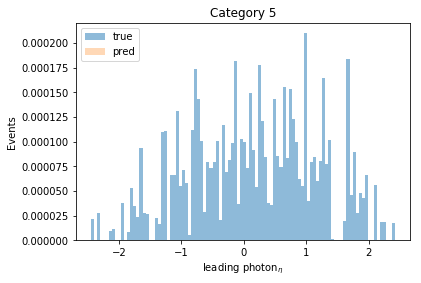

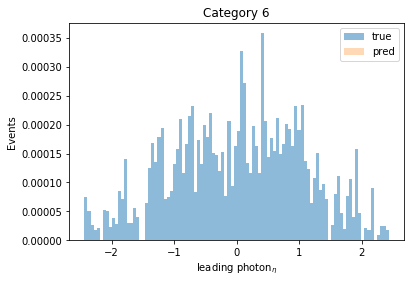

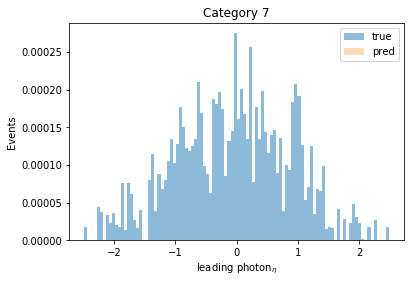

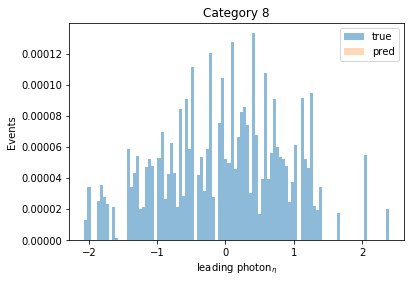

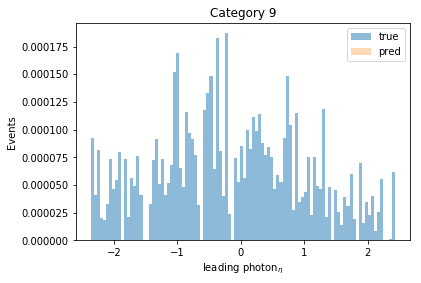

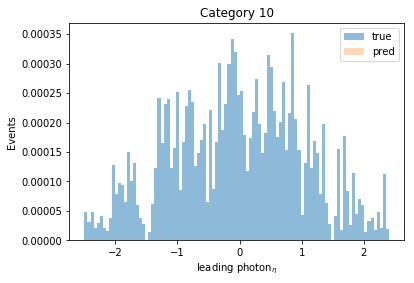

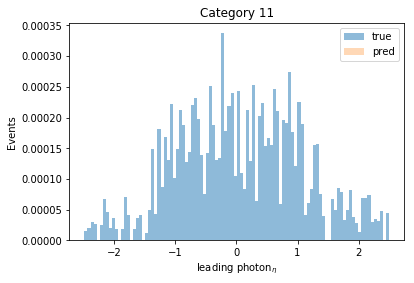

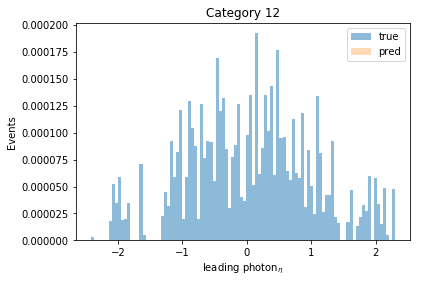

In [24]:
for i in range (0,13):
    cat_true=df[df.cat_true==i]
    cat_pred=df[df.cat_pred==i]
    plt.hist(cat_true['leadPho_eta'].ravel(),weights=cat_true.w_true.ravel(),bins=100,alpha=0.5,label='true')
    plt.hist(cat_pred['leadPho_eta'].ravel(),weights=cat_pred.w_pred.ravel(),bins=100,alpha=0.3,label='pred')
    plt.ylabel("Events")
    plt.xlabel("leading photon$_{\eta}$")
    plt.title('Category %d'%i)
    plt.legend()
    plt.show()
    plt.close()